In [ ]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

In [ ]:
!pip install langchain-community


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00


In [ ]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [ ]:
from google.colab import userdata
openai_api_key = userdata.get('openapikey')

In [ ]:
output_path = "./images"


In [ ]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename="/content/AC-Aids-for-Dogs_Canine-Periodontal-Disease.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.

In [ ]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [ ]:
!pip install transformers torch


In [ ]:

# Get image summaries
image_elements = []
image_summaries = []
import openai
from transformers import CLIPModel, CLIPProcessor
from PIL import Image

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def encode_image(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    return outputs

# def encode_image(image_path):
#     with open(image_path, "rb") as f:
#         return base64.b64encode(f.read()).decode('utf-8')

# Function to get a textual summary
# Function to get a textual summary
# def summarize_image(encoded_image):
#     # Convert tensor to list
#     encoded_image_list = encoded_image.tolist()

#     # Use the encoded image features to generate a summary with the new API
#     response = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo",
#         messages=[
#             {
#                 "role": "system",
#                 "content": "You are a helpful assistant."
#             },
#             {
#                 "role": "user",
#                 "content": f"Generate a summary for the following image features: {encoded_image_list}"
#             }
#         ],
#         max_tokens=50
#     )
#     return response['choices'][0]['message']['content'].strip()


# Function to get a textual summary
# def summarize_image(encoded_image):
#     # Convert tensor to list
#     encoded_image_list = encoded_image.cpu().detach().numpy().tolist()

#     # Use the encoded image features to generate a summary with the new API
#     response = openai.Completion.create(
#         model="text-davinci-003",
#         prompt=f"Generate a summary for the following image features: {encoded_image_list}",
#         max_tokens=50
#     )
#     return response.choices[0].text.strip()

def summarize_image(encoded_image):
    # Convert tensor to list
    encoded_image_list = encoded_image.tolist()

    # Use the encoded image features to generate a summary with GPT-3.5 Turbo
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to Dog's health."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image.{encoded_image_list}"
            },
            # {
            #     "type": "image_url",
            #     "image_url": {
            #         "url": f"data:image/jpeg;base64,{encoded_image}"
            #     },
            # },
        ])
    ]
    response = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 27.7 MB/s eta 0:00:00


In [ ]:

# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
vectorstore.save_local("faiss_index")

In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [ ]:
db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [ ]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [ ]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [ ]:
def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [ ]:
result, relevant_images = answer("What is Gingivitis?")
print(result)

Gingivitis is a common form of periodontal disease in dogs that is characterized by inflammation of the gums. It is typically caused by the accumulation of plaque along the gumline, leading to irritation and redness of the gums. If left untreated, gingivitis can progress to more severe periodontal disease, potentially causing pain, infection, abscesses, and tooth loss in dogs. Regular dental care and professional cleanings can help prevent and treat gingivitis in dogs.


In [ ]:
relevant_images[0]

tensor([[ 3.6185e-01, -4.6712e-01,  2.4411e-01, -4.8606e-02, -1.6717e-01,
          6.5295e-02, -5.1602e-01,  5.0900e-01, -5.4800e-01,  9.4658e-02,
          2.7083e-01,  1.2258e-01,  6.4133e-01,  4.8218e-02,  2.2932e-01,
          5.7688e-01,  4.1314e-01,  2.6177e-01,  1.5845e-01, -1.0288e-01,
         -5.6589e-01,  9.7690e-02, -9.5719e-02, -5.4196e-01, -8.9830e-02,
         -1.8106e-01, -3.2562e-01,  4.0886e-03,  3.2479e-01, -2.3416e-01,
          8.3923e-02, -1.5671e-01,  3.1429e-01, -3.6439e-01, -4.5929e-01,
         -3.2258e-02, -4.6586e-01,  9.2936e-02, -3.4521e-01, -4.3290e-01,
          8.5310e-03,  4.0394e-01, -1.4704e-01, -3.7642e-03,  4.1868e-02,
         -6.7429e-01,  2.7983e-01,  2.8713e-01,  5.7737e-02,  3.0883e-01,
          6.7217e-02, -1.2114e-01,  3.0623e-01,  1.8967e-01,  7.7659e-01,
          5.2437e-01, -1.3684e-01,  1.1687e-01, -1.1939e-01,  2.0355e-01,
          2.5328e-01,  4.5170e-01,  2.9367e-01, -1.2723e-01, -2.1186e-01,
          2.1462e-01,  8.2521e-02, -3.

In [ ]:
image_tensor = relevant_images[0]

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


Shape of the tensor: torch.Size([1, 512])


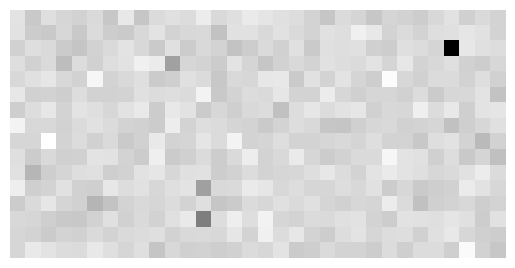

In [ ]:
# Assuming relevant_images[0] is your tensor
relevant_image_tensor = relevant_images[0]

# Check the shape of the tensor
print("Shape of the tensor:", relevant_image_tensor.shape)

# Detach the tensor from the computation graph and convert to a numpy array
image_np = relevant_image_tensor.detach().numpy()

# Reshape the array to a suitable format for visualization
# Since the original shape is (1, 512), we can reshape it to (16, 32)
image_np = image_np.reshape(16, 32)

# Normalize the values to be between 0 and 1 if they are not already
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Display the image
plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.show()

Shape of the tensor: torch.Size([1, 512])


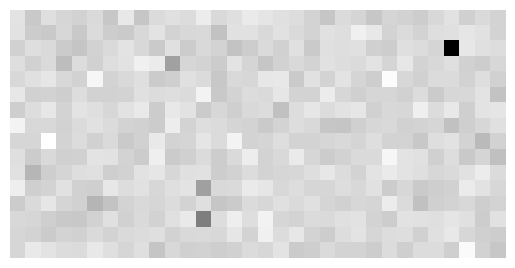

In [ ]:
# Assuming relevant_images[0] is your tensor
relevant_image_tensor = relevant_images[0]

# Check the shape of the tensor
print("Shape of the tensor:", relevant_image_tensor.shape)

# Detach the tensor from the computation graph and convert to a numpy array
image_np = relevant_image_tensor.detach().numpy()

# Reshape the array to a suitable format for visualization
# Since the original shape is (1, 512), we can reshape it to (16, 32)
image_np = image_np.reshape(16, 32)

# Normalize the values to be between 0 and 1 if they are not already
# Ensure that the range is correct based on the expected data range
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Display the image using grayscale colormap
plt.imshow(image_np, cmap='gray')

# Remove axis
plt.axis('off')

# Show the plot
plt.show()